In [1]:
import tensorflow as tf
print(tf.__version__)

import cv2

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
import string
from numpy import array
from pickle import load
import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
# from keras.backend.tensorflow_backend import set_session

import tensorflow as tf
import datetime
# warnings.filterwarnings("ignore")
import re
from tensorflow.python.keras.backend import set_session
import keras
import sys, time, os, warnings 
from pickle import dump

from collections import Counter
from tqdm import tqdm
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.layers import LSTM
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2.3.1


Using TensorFlow backend.


In [2]:
class VGG16_Encoder(tf.keras.Model):

    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        

In [3]:
def rnn_type(units):

    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

# Here we provide you the choice of using Local Attention or Global Attention for the Decoder

In [4]:
class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

    attention_weights = tf.nn.softmax(score, axis=1)
    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x= self.dropout(x)
    x= self.batchnormalization(x)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## RNN DECODER AND LUONG ATTENTION(GLOBAL ATTENTION)

In [5]:
embedding_dim = 256
units = 512
vocab_size = 8362

In [6]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [7]:
decoder

In [8]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

In [10]:
checkpoint_path_ckpt = "./checkpoint_finally19/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [11]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [12]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-04-24 20:19:19.472188: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-04-24 20:19:19.472231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "/home/abhishek/.local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/abhishek/.local/lib/python3.5/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/home/abhishek/.local/lib/python3.5/site-packages/tensorboard/default.py", line 108, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/home/abhishek/.local/lib/python3.5/site-packages/tensorboard/default.py", line 146, in get_dynamic_plugins
   

In [13]:
ckpt_manager.checkpoints

['./checkpoint_finally19/train/ckpt-2',
 './checkpoint_finally19/train/ckpt-3',
 './checkpoint_finally19/train/ckpt-4',
 './checkpoint_finally19/train/ckpt-5',
 './checkpoint_finally19/train/ckpt-6']

In [14]:
ckpt.restore('./checkpoint_finally19/train/ckpt-6')

In [15]:
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [16]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
image_features_extract_model = tf.keras.Model(image_model.input, image_model.layers[-1].output)

In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path


In [18]:
def evaluate(image):
    
    result = []
    
    max_length = 34
    attention_features_shape = 49
    
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    start_str = '<start>'
    end_str = '<end>'
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    
    val1 = img_tensor_val.shape[0]
    val3 = img_tensor_val.shape[3]

    img_tensor_val = tf.reshape(img_tensor_val, (val1, -1, val3))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index[start_str]], 0) 

    for i in range(0,max_length,1):
        
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0])
        predicted_id = predicted_id.numpy()
        
        result.append(tokenizer.index_word[predicted_id]) 

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
#         attention_plot[i] = attention_plot[i].numpy()


        if tokenizer.index_word[predicted_id] == end_str: 
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    res_len = len(result)
    attention_plot = attention_plot[:res_len, :]
    return result, attention_plot

### Let's create a helper function to visualise the attention points that predicts the words.

In [19]:
def plot_attention(image, result, attention_plot):
    
    tmp = Image.open(image)
    temp_image = np.array(tmp)
    
    if len(attention_plot) < len(result):
        len_result = len(attention_plot)
    else:
        len_result = len(result)

    fig = plt.figure(figsize=(50, 50))
        
    for l in range(0,len_result,1):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(10, 10, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
    plt.show()


In [20]:
def get_caption(img):
    start = time.time()
    result, attention_plot = evaluate(img)

    start_str = '<start>'
    end_str = '<end>'
    unk_str = "<unk>"

    #remove "<unk>" in result
    for i in result:
        if i==unk_str:
            result.remove(i)

    result_join = ''
    for i in range(len(result)):
        result_join += str(result[i])
        
        if i!=len(result)-1:
            result_join += ' '
        
        
    result_final = result_join.rsplit(end_str)
    result_final = result_final[0]
    candidate = result_final.split(" ")


    print ('Prediction Caption:', result_final)

    plot_attention(img, candidate, attention_plot)

    


Prediction Caption: young boy is ready to his head 


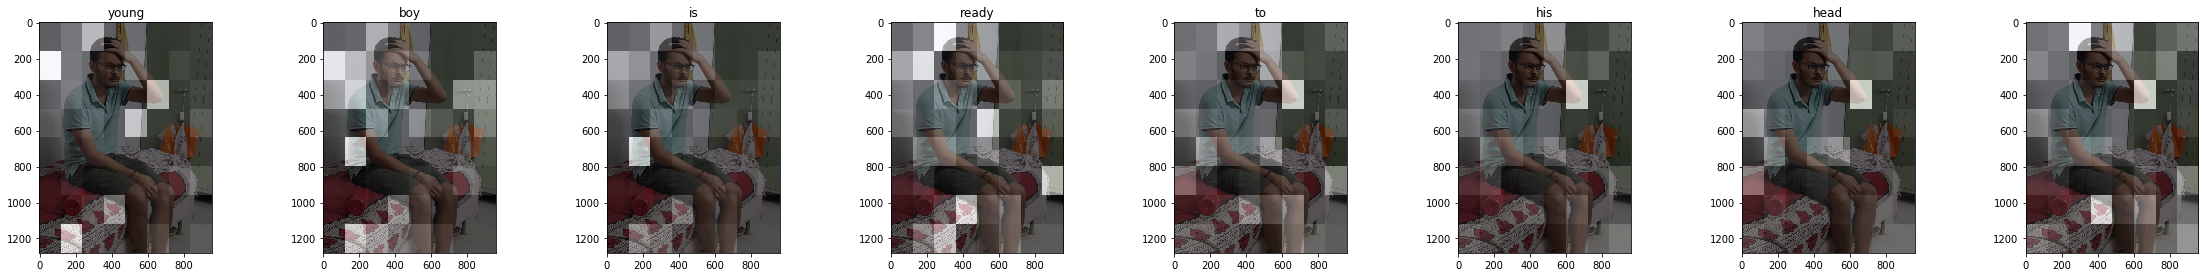

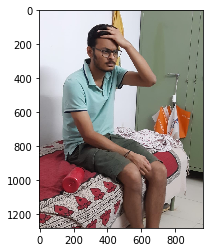

In [21]:
image = "./images/my.jpeg"
get_caption(image)
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Prediction Caption: man in blue shirt smiles on top of another 


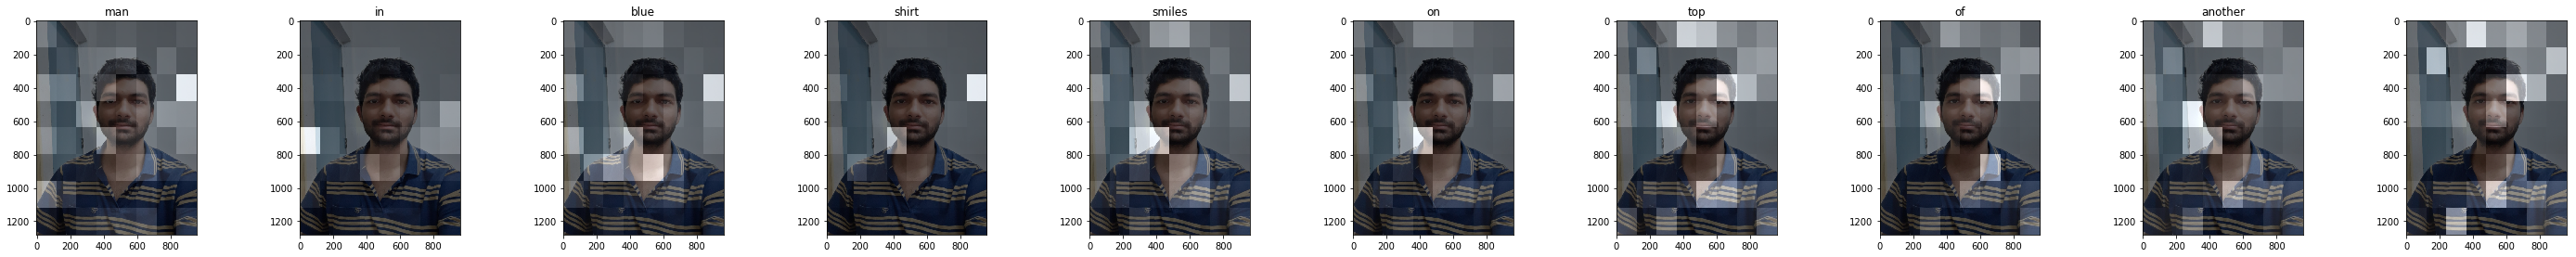

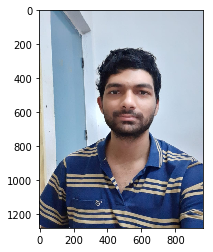

In [22]:
image = "./images/amogh1.jpeg"
get_caption(image)
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Prediction Caption: man dressed in blue is ready to the hands 


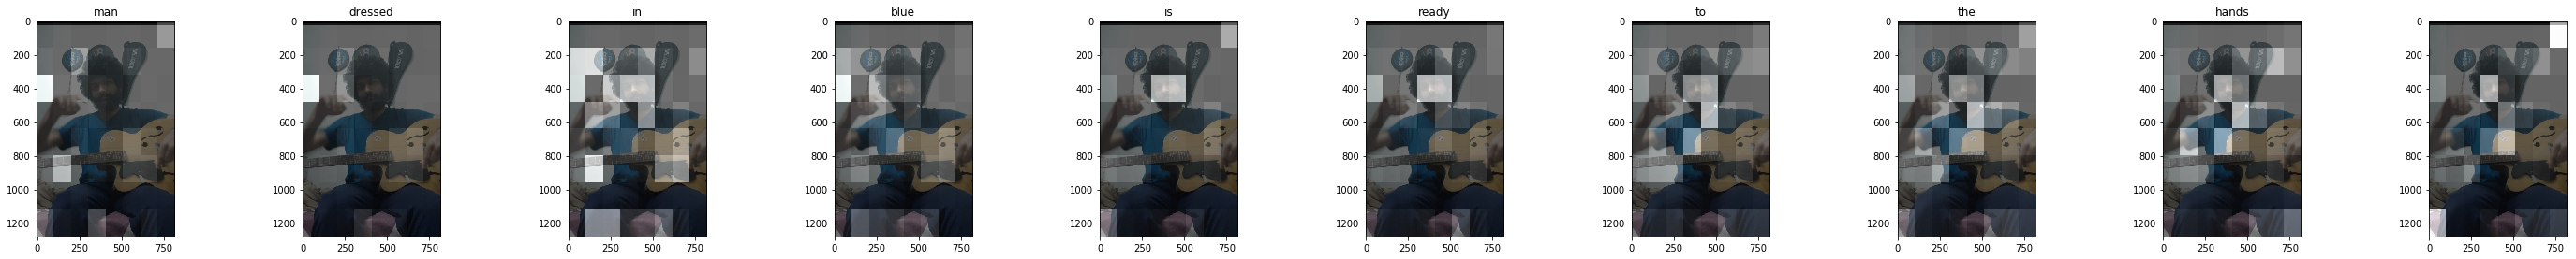

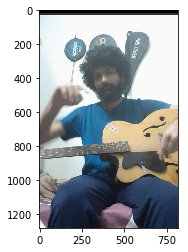

In [23]:
image = "./images/amogh2.jpeg"
get_caption(image)
img = cv2.imread(image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)